# RAFT IVF Flat Example Notebook

## Introduction

This notebook demonstrates how to run approximate nearest neighbor search using RAFT IVF-Flat algorithm.

In [1]:
import os
import cupy as cp
import numpy as np
from pylibraft.common import DeviceResources
from pylibraft.neighbors import ivf_flat
import time
import matplotlib.pyplot as plt
import h5py
import tempfile
import urllib.request

For best performance it is recommended to use an RMM pooling allocator, to minimize the overheads of repeated CUDA allocations.

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
mr = rmm.mr.PoolMemoryResource(
     rmm.mr.CudaMemoryResource(),
     initial_pool_size=2**30
)
rmm.mr.set_current_device_resource(mr)
cp.cuda.set_allocator(rmm_cupy_allocator)

The following GPU is used for this notebook

In [3]:
# Report the GPU in use
!nvidia-smi

Mon Sep 18 03:01:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10                     On  | 00000000:81:00.0 Off |                    0 |
|  0%   37C    P0              56W / 150W |   1264MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Utility functions

In [4]:
def calc_recall(ann_idx, true_nn_idx):
    k = ann_idx.shape[1]
    if k > true_nn_idx.shape[1]:
        raise RuntimeError(
            "Incompatible shapes {} vs {}".format(ann_idx.shape, true_nn_idx.shape)
        )
    
    n = 0
    for i in range(ann_idx.shape[0]):
        n += cp.intersect1d(ann_idx[i, :], true_nn_idx[i, :k]).size
    recall = n / ann_idx.size
    return recall

class BenchmarkTimer:
    """Provides a context manager that runs a code block `reps` times
    and records results to the instance variable `timings`. Use like:
    .. code-block:: python
        timer = BenchmarkTimer(rep=5)
        for _ in timer.benchmark_runs():
            ... do something ...
        print(np.min(timer.timings))

        This class is borrowed from the rapids/cuml benchmark suite
    """

    def __init__(self, reps=1, warmup=0):
        self.warmup = warmup
        self.reps = reps
        self.timings = []

    def benchmark_runs(self):
        for r in range(self.reps + self.warmup):
            t0 = time.time()
            yield r
            t1 = time.time()
            self.timings.append(t1 - t0)
            if r >= self.warmup:
                self.timings.append(t1 - t0)

## Load dataset

The ANN benchmarks website provides the datasets in HDF5 format.

The list of prepared datasets can be found at https://github.com/erikbern/ann-benchmarks/#data-sets

In [5]:
#DATASET_URL = "http://ann-benchmarks.com/glove-100-angular.hdf5"
DATASET_URL = "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
DATASET_FILENAME = DATASET_URL.split('/')[-1]

# We'll need to load store some data in this tutorial
WORK_FOLDER = os.path.join(tempfile.gettempdir(), 'raft_ivf_flat_example')

if not os.path.exists(WORK_FOLDER):
   os.makedirs(WORK_FOLDER)
print("The index and data will be saved in", WORK_FOLDER)

## download the dataset
dataset_path = os.path.join(WORK_FOLDER, DATASET_FILENAME)
if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(DATASET_URL, dataset_path)

The index and data will be saved in /tmp/raft_ivf_flat_example


In [6]:
f = h5py.File(dataset_path, "r")

metric = f.attrs['distance']

dataset = cp.array(f['train'])
queries = cp.array(f['test'])
gt_neighbors = cp.array(f['neighbors'])
gt_distances = cp.array(f['distances'])

itemsize = dataset.dtype.itemsize 

print(f"Loaded dataset of size {dataset.shape}, {dataset.size*itemsize/(1<<30):4.1f} GiB; metric: '{metric}'.")
print(f"Number of test queries: {queries.shape[0]}")

Loaded dataset of size (1000000, 128),  0.5 GiB; metric: 'euclidean'.
Number of test queries: 10000


## Build index

In [7]:
%%time
build_params = ivf_flat.IndexParams(
        n_lists=1024,
        metric="euclidean",
        kmeans_trainset_fraction=0.1,
        kmeans_n_iters=20,
        add_data_on_build=True
    )

index = ivf_flat.build(build_params, dataset)

CPU times: user 189 ms, sys: 32.3 ms, total: 222 ms
Wall time: 226 ms


The index is built. We can print some basic information of the index

In [8]:
print(index)

Index(type=IVF-FLAT, metric=euclidean, size=1000000, dim=128, n_lists=1024, adaptive_centers=False)


## Search neighbors

It is recommended to reuse devece recosources accross multiple invacations of search. 

In [9]:
handle = DeviceResources()

In [11]:
%%time
n_queries=10000
# n_probes is the number of clusters we select in the first (coarse) search step. This is the only hyper parameter for search.
search_params = ivf_flat.SearchParams(n_probes=30)

# Search 10 nearest neighbors.
distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)

CPU times: user 165 ms, sys: 141 ms, total: 306 ms
Wall time: 303 ms


The returnad arrays have shappe {n_queries x 10] and store the distance values and the indices of the searched vectors.

In [12]:
calc_recall(neighbors, gt_neighbors)

0.974

## Save and load the index
You can serialize the index to file, and load it later.

In [13]:
index_file = os.path.join(WORK_FOLDER, "my_ivf_flat_index.bin")
ivf_flat.save(index_file, index)

In [14]:
index = ivf_flat.load(index_file)

## Tune search parameters
Search has a single hyper parameter: `n_probes`, which describes how many neighboring cluster is searched (probed) for each query. Within a probed cluster, the distance is computed between all the vectors in the cluster and the query point, and the top-k neighbors are selected. Finally, the top-k neighobrs are selected from all the neighbor candidates from the probed clusters.

Let's see how search accuracy and latency changes when we change the `n_probes` parameter.

In [15]:
n_probes = np.asarray([10, 20, 30, 50, 100, 200, 500, 1024]);
qps = np.zeros(n_probes.shape);
recall = np.zeros(n_probes.shape);

for i in range(len(n_probes)):
    print("\nBenchmarking search with n_probes =", n_probes[i])
    timer = BenchmarkTimer(reps=1, warmup=1)
    for rep in timer.benchmark_runs():
        distances, neighbors = ivf_flat.search(
            ivf_flat.SearchParams(n_probes=n_probes[i]),
            index,
            cp.asarray(queries),
            k=10,
            handle=handle,
        )
    
    recall[i] = calc_recall(cp.asnumpy(neighbors), gt_neighbors)
    print("recall", recall[i])

    timings = np.asarray(timer.timings)
    avg_time = timings.mean()
    std_time = timings.std()
    qps[i] = queries.shape[0] / avg_time
    print("Average search time: {0:7.3f} +/- {1:7.3} s".format(avg_time, std_time))
    print("Queries per second (QPS): {0:8.0f}".format(qps[i]))


Benchmarking search with n_probes = 10
recall 0.86509
Average search time:   0.067 +/-  0.0464 s
Queries per second (QPS):   148962

Benchmarking search with n_probes = 20
recall 0.94818
Average search time:   0.133 +/-  0.0932 s
Queries per second (QPS):    75407

Benchmarking search with n_probes = 30
recall 0.974
Average search time:   0.198 +/-    0.14 s
Queries per second (QPS):    50476

Benchmarking search with n_probes = 50
recall 0.99152
Average search time:   0.328 +/-   0.232 s
Queries per second (QPS):    30450

Benchmarking search with n_probes = 100
recall 0.99827
Average search time:   0.652 +/-    0.46 s
Queries per second (QPS):    15330

Benchmarking search with n_probes = 200
recall 0.99926
Average search time:   1.266 +/-   0.894 s
Queries per second (QPS):     7901

Benchmarking search with n_probes = 500
recall 0.99933
Average search time:   2.881 +/-    2.04 s
Queries per second (QPS):     3471

Benchmarking search with n_probes = 1024
recall 0.99933
Average sea

The plots below illustrate how the accuracy (recall) and the throughput (queries per second) depends on the `n_probes` parameter.

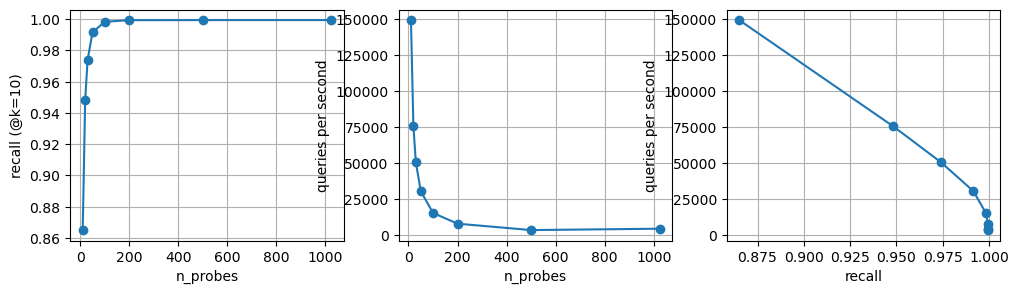

In [17]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax.plot(n_probes, recall,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('n_probes')
ax.grid()
ax.set_ylabel('recall (@k=10)')

ax = fig.add_subplot(132)
ax.plot(n_probes, qps,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('n_probes')
ax.grid()
ax.set_ylabel('queries per second');

ax = fig.add_subplot(133)
ax.plot(recall, qps,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('recall')
ax.grid()
ax.set_ylabel('queries per second');
#ax.set_yscale('log')

## Adjust build parameters
### n_lists
The number of clusters (or lists) is set by the n_list parameter. Let's change it to 100 clusters.

In [18]:
%%time
build_params = ivf_flat.IndexParams(
        n_lists=100,
        metric="euclidean",
        kmeans_trainset_fraction=1,
        kmeans_n_iters=20,
        add_data_on_build=True
    )

index = ivf_flat.build(build_params, dataset, handle=handle)

CPU times: user 536 ms, sys: 15.3 ms, total: 551 ms
Wall time: 545 ms


The ratio of n_probes / n_list will determine how large fraction of the dataset is searched for each query. The right combination depends on the use case. Here we will search 10 of the clusters for each query.

In [19]:
%%time
n_queries=10000

search_params = ivf_flat.SearchParams(n_probes=10)

# Search 10 nearest neighbors.
distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)

CPU times: user 598 ms, sys: 392 ms, total: 990 ms
Wall time: 985 ms


In [20]:
calc_recall(neighbors, gt_neighbors)

0.9884

### trainset_fraction
During clustering we can sub-sample the dataset. The parameter `trainset_fraction` determines what fraction to use. Often we get good results by using only 1/10th of the dataset for clustering. 

In [21]:
%%time
build_params = ivf_flat.IndexParams( 
        n_lists=100, 
        metric="sqeuclidean", 
        kmeans_trainset_fraction=0.1, 
        kmeans_n_iters=20 
    ) 
index = ivf_flat.build(build_params, dataset, handle=handle)

CPU times: user 76.6 ms, sys: 27 µs, total: 76.6 ms
Wall time: 76.2 ms


We see only a minimal change in the recall

In [22]:
search_params = ivf_flat.SearchParams(n_probes=10)

distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)
calc_recall(neighbors, gt_neighbors)

0.98798

### Add vectors on build
Currently you cannot configure how RAFT sub-samples the input. If you want to have a fine control on how the training set is selected, then create the index in two steps:
1. Define cluster centers on a training set, but do not add any vector to the index
2. Add vectors to the index (extend)

This workflow shall be familiar to FAISS users. Note that raft does not require adding the data in batches, internal batching is used when necessary.


In [23]:
# subsample the dataset
n_train = 10000
train_set = dataset[cp.random.choice(dataset.shape[0], n_train, replace=False),:]

# build using training set
build_params = ivf_flat.IndexParams(
        n_lists=1024,
        metric="sqeuclidean",
        kmeans_trainset_fraction=1,
        kmeans_n_iters=20,
        add_data_on_build=False
    )
index = ivf_flat.build(build_params, train_set)

print("Index before adding vectors", index)

ivf_flat.extend(index, dataset, cp.arange(dataset.shape[0], dtype=cp.int64))

print("Index after adding vectors", index)

Index before adding vectors Index(type=IVF-FLAT, metric=sqeuclidean, size=0, dim=128, n_lists=1024, adaptive_centers=False)
Index after adding vectors Index(type=IVF-FLAT, metric=sqeuclidean, size=1000000, dim=128, n_lists=1024, adaptive_centers=False)
